# Validate Pole and Zero model using metal block AE sensor Calibration
2022.08.15 Kurama Okubo

- 2025.3.12 update for master plot. We changed frequency range and modified LDV correction factor.
- 2025.3.14 change the NMSE to normalized root mean square error (NRMSE)

## Work flow

1. Compute poles and zeros with Matlab lsq_arx().
2. load data.
3. apply remove_resp_digitalfilt():
4. compute Normalized mean square error

In [1]:
import os
import obspy
from obspy import read, Stream, Trace
from obspy.signal.invsim import paz_to_freq_resp

from scipy import signal
import scipy.io as sio
import matplotlib.pyplot as plt
%matplotlib inline
import glob
from glob import glob
import numpy as np
import pandas as pd
import datetime
from datetime import timedelta
from tqdm import tqdm
import warnings

%load_ext autoreload
%autoreload 2

from remove_resp_digitalfilt import *

os.environ['TZ'] = 'GMT' # change time zone to avoid confusion in unix_tvec conversion

plt.rcParams["font.family"] = 'Arial'
# plt.rcParams["font.sans-serif"] = "DejaVu Sans, Arial, Helvetica, Lucida Grande, Verdana, Geneva, Lucid, Avant Garde, sans-serif"
plt.rcParams["font.size"] = 12
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["xtick.major.size"] = 4.75
plt.rcParams["xtick.major.width"] = 0.75
plt.rcParams["xtick.minor.size"] = 3
plt.rcParams["xtick.minor.width"] = 0.4
plt.rcParams["xtick.minor.visible"] = True

plt.rcParams["ytick.direction"] = "in"
plt.rcParams["ytick.major.size"] = 4.75
plt.rcParams["ytick.major.width"] = 0.75
plt.rcParams["ytick.minor.size"] = 3
plt.rcParams["ytick.minor.width"] = 0.4
plt.rcParams["ytick.minor.visible"] = True

plt.rcParams["savefig.transparent"] = True

plt.rcParams['axes.linewidth'] = 0.75
    
os.environ['TZ'] = 'GMT' # change time zone to avoid confusion in unix_tvec conversion

In [2]:
figdir="../figure/validation/"
if not os.path.isdir(figdir):
    os.mkdir(figdir)

In [3]:
# load PAZ
casename_list = ["frontcenter", "fronttop", "sidecenter"]

ic = 1 # index of cases to plot: run each case to plot figures

casename = casename_list[ic]

D = sio.loadmat("../data/AE_resp_dataandcoef_{}.mat".format(casename));
D.keys()

poles = np.squeeze(D["p"])
zeros = np.squeeze(D["z"])
scale_fac = np.squeeze(D["k"])
u_normfact = np.squeeze(D["u_normfact"])
AIC_best = np.squeeze(D["AIC_best"])
pre_filt = (1e4, 2e4, 2e6, 4e6) # pre-filter when apply the deconvolution
water_level = 60

fs = 1e7 # sampling frequency of LDV and AE sensor
NT = 1001 #number of data point for the trace


In [4]:
scale_fac

array(894.99095553)

In [5]:
# read traces
# C00:master, C01: validate front, C02: validate side
st_u = Stream() # input: LDV
st_y = Stream() # output: AE sensor

SourceCorrectionFactor = 1.79 # As the source of LDV is 200V while the AE sensor is 100V due to the recording range, correct it with the linear assumption.

for i, finame in enumerate(casename_list):
# i = 0    
    finame = casename_list[i]

    df_tr_LDV = pd.read_csv("../../AEsensor_Calibration_DataConversion/data/LDV_{}_S200V.csv".format(finame))
    df_tr_AE = pd.read_csv("../../AEsensor_Calibration_DataConversion/data/AE_{}_S100V.csv".format(finame))

    tr = Trace()
    tr.stats.starttime = datetime.datetime(2022,8,15)
    tr.stats.sampling_rate = fs
    tr.stats.network = "N"
    tr.stats.station = "C{:02d}".format(i)
    tr.stats.channel = "UZ"
    tr.stats.casename=finame
    tr.data = np.array(df_tr_LDV["LDV"])[:NT] / SourceCorrectionFactor
    st_u.append(tr.copy())
    tr.stats.channel = "YZ"
    tr.data = np.array(df_tr_AE["AE"])[:NT]
    st_y.append(tr.copy())



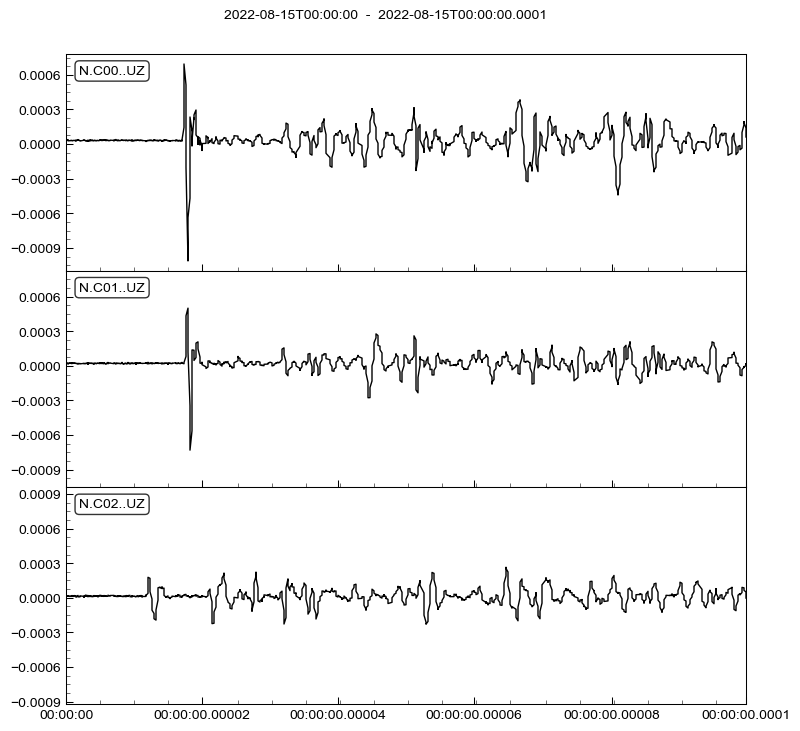

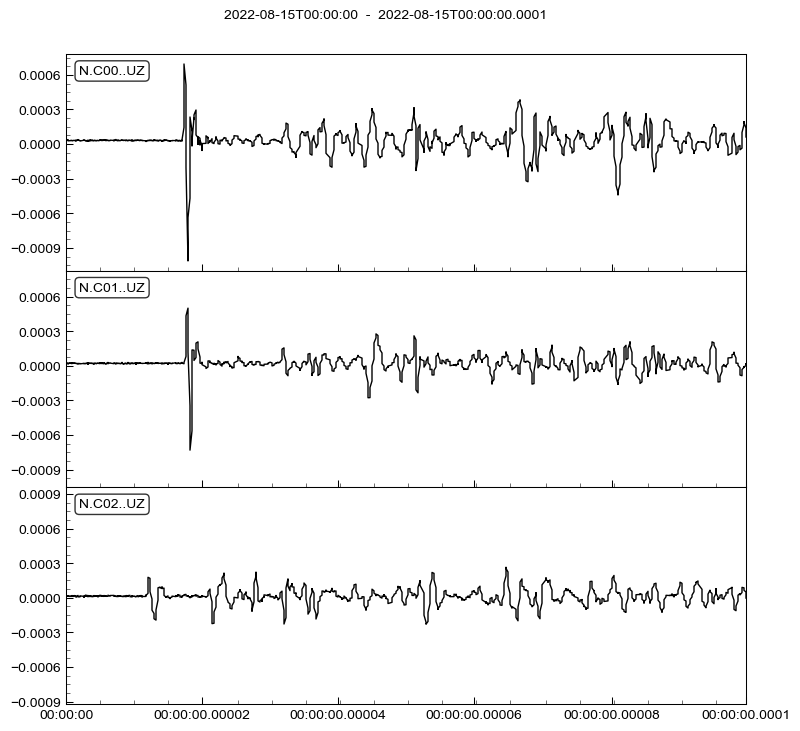

In [6]:
st_u.plot()

(15.0, 20.0)

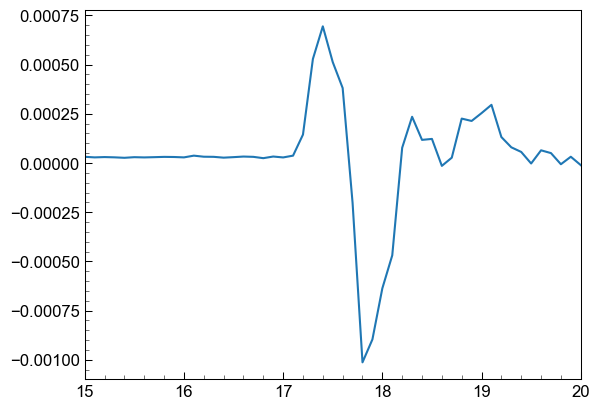

In [7]:
plt.plot(st_u[0].times()*1e6, st_u[0].data)
plt.xlim([15, 20])

## Plot rawdata spectrum

In [8]:
F = []
for tr in st_u:
    F.append(np.fft.rfft(tr.data))

freq = np.fft.rfftfreq(st_u[0].stats.npts, st_u[0].stats.delta)

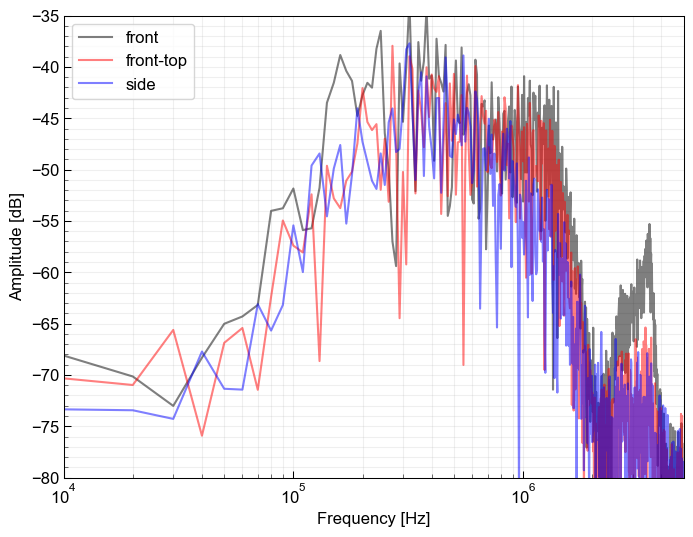

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
xlimit = [10e3, 5e6]

ax.grid(True, which="both", ls="-", alpha=0.2)

ax.semilogx(freq, 20 * np.log10(abs(F[0])), "k-", label="front", alpha=0.5)
ax.semilogx(freq, 20 * np.log10(abs(F[1])), "r-", label="front-top", alpha=0.5)
ax.semilogx(freq, 20 * np.log10(abs(F[2])), "b-", label="side", alpha=0.5)

ax.set_xlabel("Frequency [Hz]")
ax.set_ylabel("Amplitude [dB]")
ax.set_xlim(xlimit)
ax.set_ylim([-80, -35])
ax.legend(loc=2)

plt.savefig(figdir+"/LDVspectrum_comparison.png".format(casename), dpi=300)


## Plot master data

In [10]:
tr_u = st_u.select(station="C{:02d}".format(ic))[0]
tr_y = st_y.select(station="C{:02d}".format(ic))[0]
# scale fac (i.e. k) is scaled with u_norm fact, which is used during the evaluation of ARX. 
tr_removed, freqs, freq_domain_taper, data_after_freqtapered, freq_response_forward, freq_response = remove_resp_digitalfilt(tr_y, poles, zeros, scale_fac, pre_filt=pre_filt, water_level=60, zero_mean=True,
    taper=True, taper_fraction=0.05, detrend=True, debug=True)

In [11]:
freqmin = 1e5 #6e4
freqmax = 1e6 #3e5

tr_y_filtered = tr_y.copy().filter("bandpass", freqmin=freqmin, freqmax=freqmax, corners=3, zerophase=True)
tr_u_filtered = tr_u.copy().filter("bandpass", freqmin=freqmin, freqmax=freqmax, corners=3, zerophase=True)
tr_inv_filtered = tr_removed.copy().filter("bandpass", freqmin=freqmin, freqmax=freqmax, corners=3, zerophase=True)


Text(0, 0.5, 'velocity [mm/s]')

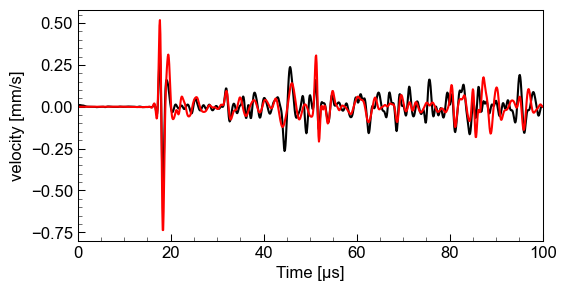

In [12]:

fig, ax = plt.subplots(1, 1, figsize=(6, 3))
tvec = tr_u.times()*1e6
# ax.plot(tvec, tr_y_filtered.data/20e3, "g-", label="AE")
ax.plot(tvec, tr_u_filtered.data*1e3, "k-", label="LDV")
ax.plot(tvec, tr_inv_filtered.data*1e3, "r-", label="inverted")
# ax.plot(tvec, tr_y_filtered.data/5e4, "b--", label="inverted")
ax.set_xlim([0, 100])
ax.set_xlabel("Time [μs]")
ax.set_ylabel("velocity [mm/s]")



In [13]:
tr_u.stats

         network: N
         station: C01
        location: 
         channel: UZ
       starttime: 2022-08-15T00:00:00.000000Z
         endtime: 2022-08-15T00:00:00.000100Z
   sampling_rate: 10000000.0
           delta: 1e-07
            npts: 1001
           calib: 1.0
        casename: fronttop

In [14]:
# compute G from just dividing y from u
from obspy.signal.util import _npts2nfft
nfft = _npts2nfft(tr_y.stats.npts)
U = np.fft.rfft(tr_u.data, n=nfft)
Y = np.fft.rfft(tr_y.data, n=nfft)
g_freqs = np.fft.rfftfreq(nfft, d=1/fs)
g_est = Y/U

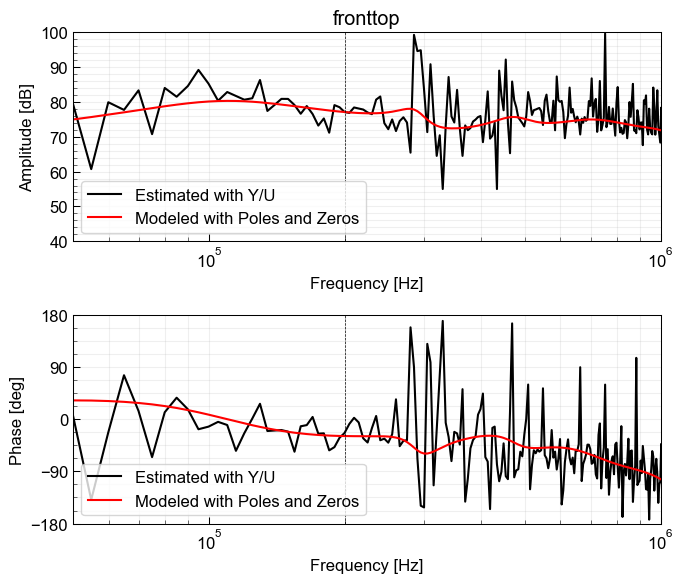

In [15]:
fig, axs = plt.subplots(2, 1, figsize=(7, 6))
xlimit = [5e4, 1e6]

axs[0].grid(True, which="both", ls="-", alpha=0.2)

axs[0].semilogx(g_freqs, 20 * np.log10(abs(g_est)), "k-", label="Estimated with Y/U")
axs[0].semilogx(freqs, 20 * np.log10(abs(freq_response_forward)), "r-", label="Modeled with Poles and Zeros")

axs[0].set_xlabel("Frequency [Hz]")
axs[0].set_ylabel("Amplitude [dB]")
axs[0].set_xlim(xlimit)
axs[0].set_ylim([40, 100])
axs[0].legend(loc=3)
axs[0].set_title(casename)

if ic in [0, 1]:
    axs[0].axvline(2e5, ls="--", c="k", lw=0.5)
elif ic in [2]:
    axs[0].axvline(1e5, ls="--", c="k", lw=0.5)


# angles_gest = np.unwrap(np.angle(g_est)) # unwrap the angle to make it continuous; not applied for this figure
# angles_paz = np.unwrap(np.angle(freq_response_forward))
angles_gest = np.angle(g_est)
angles_paz = np.angle(freq_response_forward)

axs[1].grid(True, which="both", ls="-", alpha=0.2)

axs[1].semilogx(g_freqs, np.rad2deg(angles_gest), 'k', label="Estimated with Y/U")
axs[1].semilogx(freqs, np.rad2deg(angles_paz), 'r', label="Modeled with Poles and Zeros")

axs[1].set_xlabel("Frequency [Hz]")
axs[1].set_ylabel('Phase [deg]')
axs[1].set_ylim([-180, 180])
axs[1].set_yticks([-180, -90, 0, 90, 180])
axs[1].set_xlim(xlimit)
axs[1].legend(loc=3)

if ic in [0, 1]:
    axs[1].axvline(2e5, ls="--", c="k", lw=0.5)
elif ic in [2]:
    axs[1].axvline(1e5, ls="--", c="k", lw=0.5)

    
plt.tight_layout()
# plt.savefig(figdir+"/AEsensor_bode_{}.pdf".format(casename), dpi=300)


## Plot validation data

In [16]:
taper_max_percentage = 0.1# taper percentage after bandpass

In [17]:
tr_u_C00 = st_u.select(station="C00")[0]
tr_y_C00 = st_y.select(station="C00")[0]
tr_removed_C00 = remove_resp_digitalfilt(tr_y_C00, poles, zeros, scale_fac, pre_filt=pre_filt, water_level=90, zero_mean=True,
    taper=True, taper_fraction=0.05, detrend=True, debug=False)

tr_y_C00_filtered = tr_y_C00.copy().taper(taper_max_percentage,   type='cosine').filter("bandpass", freqmin=freqmin, freqmax=freqmax, corners=3, zerophase=True).taper(taper_max_percentage,   type='cosine')
tr_u_C00_filtered = tr_u_C00.copy().taper(taper_max_percentage,   type='cosine').filter("bandpass", freqmin=freqmin, freqmax=freqmax, corners=3, zerophase=True).taper(taper_max_percentage,   type='cosine')
tr_inv_C00_filtered = tr_removed_C00.copy().taper(taper_max_percentage,   type='cosine').filter("bandpass", freqmin=freqmin, freqmax=freqmax, corners=3, zerophase=True).taper(taper_max_percentage,   type='cosine')

Text(0.5, 1.0, 'case 00')

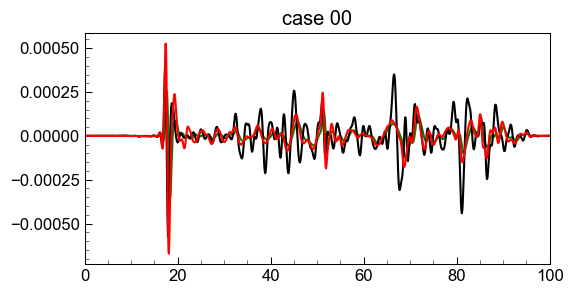

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
tvec = tr_u.times()*1e6
ax.plot(tvec, tr_y_C00_filtered.data/10e3, "g-", label="LDV")
ax.plot(tvec, tr_u_C00_filtered.data, "k-", label="LDV")
ax.plot(tvec, tr_inv_C00_filtered.data, "r-", label="inverted")
# ax.plot(tvec, tr_y_filtered.data/5e4, "b--", label="inverted")
ax.set_xlim([0, 100])
ax.set_xlim([0, 100])
ax.set_title("case 00")

In [19]:
tr_u_C01 = st_u.select(station="C01")[0]
tr_y_C01 = st_y.select(station="C01")[0]
tr_removed_C01 = remove_resp_digitalfilt(tr_y_C01, poles, zeros, scale_fac, pre_filt=pre_filt, water_level=90, zero_mean=True,
    taper=True, taper_fraction=0.05, detrend=True, debug=False)

tr_y_C01_filtered = tr_y_C01.copy().taper(taper_max_percentage,   type='cosine').filter("bandpass", freqmin=freqmin, freqmax=freqmax, corners=3, zerophase=True).taper(taper_max_percentage,   type='cosine')
tr_u_C01_filtered = tr_u_C01.copy().taper(taper_max_percentage,   type='cosine').filter("bandpass", freqmin=freqmin, freqmax=freqmax, corners=3, zerophase=True).taper(taper_max_percentage,   type='cosine')
tr_inv_C01_filtered = tr_removed_C01.copy().taper(taper_max_percentage,   type='cosine').filter("bandpass", freqmin=freqmin, freqmax=freqmax, corners=3, zerophase=True).taper(taper_max_percentage,   type='cosine')



Text(0.5, 1.0, 'case 01')

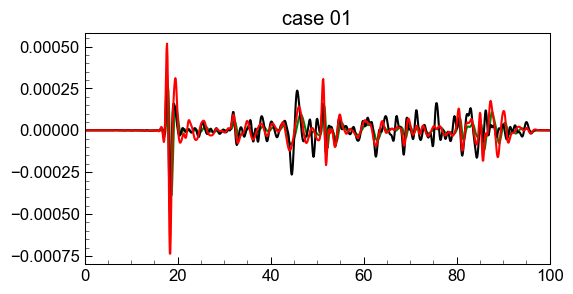

In [20]:

fig, ax = plt.subplots(1, 1, figsize=(6, 3))
tvec = tr_u.times()*1e6
ax.plot(tvec, tr_y_C01_filtered.data/10e3, "g-", label="LDV")
ax.plot(tvec, tr_u_C01_filtered.data, "k-", label="LDV")
ax.plot(tvec, tr_inv_C01_filtered.data, "r-", label="inverted")
# ax.plot(tvec, tr_y_filtered.data/5e4, "b--", label="inverted")
ax.set_xlim([0, 100])
ax.set_xlim([0, 100])

ax.set_title("case 01")


In [21]:
tr_u_C02 = st_u.select(station="C02")[0]
tr_y_C02 = st_y.select(station="C02")[0]
tr_removed_C02 = remove_resp_digitalfilt(tr_y_C02, poles, zeros, scale_fac, pre_filt=pre_filt, water_level=60, zero_mean=True,
    taper=True, taper_fraction=0.05, detrend=True, debug=False)

tr_y_C02_filtered = tr_y_C02.copy().taper(taper_max_percentage,   type='cosine').filter("bandpass", freqmin=freqmin, freqmax=freqmax, corners=3, zerophase=True).taper(taper_max_percentage,   type='cosine')
tr_u_C02_filtered = tr_u_C02.copy().taper(taper_max_percentage,   type='cosine').filter("bandpass", freqmin=freqmin, freqmax=freqmax, corners=3, zerophase=True).taper(taper_max_percentage,   type='cosine')
tr_inv_C02_filtered = tr_removed_C02.copy().filter("bandpass", freqmin=freqmin, freqmax=freqmax, corners=3, zerophase=True).taper(taper_max_percentage,   type='cosine')



Text(0.5, 1.0, 'case 02')

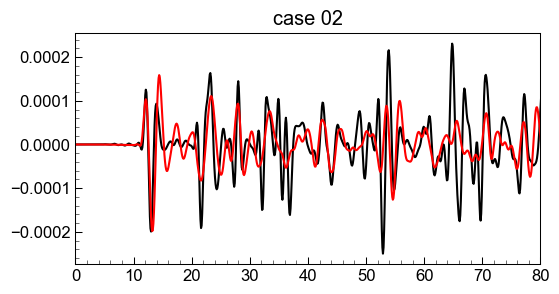

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
tvec = tr_u.times()*1e6
# ax.plot(tvec, tr_y_C02_filtered.data/8e3, "g-", label="LDV")
ax.plot(tvec, tr_u_C02_filtered.data, "k-", label="LDV")
ax.plot(tvec, tr_inv_C02_filtered.data, "r-", label="inverted")
# ax.plot(tvec, tr_y_filtered.data/5e4, "b--", label="inverted")
ax.set_xlim([0, 80])
ax.set_xlim([0, 80])

ax.set_title("case 02")


In [23]:
def compute_NMSE(uhat, uval):
    """Return normalized mean square error in %."""
    uhat = np.array(uhat)
    uval = np.array(uval)
    return np.mean(((uhat-uval)**2)/np.max(uval)**2) * 100


In [24]:
def compute_NRMSE(uhat, uval):
    """Return normalized root mean square error."""
    uhat = np.array(uhat)
    uval = np.array(uval)

    rmse = np.sqrt(np.mean((uhat - uval) ** 2))
    norm_factor = np.max(uhat) - np.min(uhat) # normalized by the max-min of the data, which avoids zero division.
    
    return rmse/norm_factor

# Plot comparison

In [25]:
Npoles = np.count_nonzero(poles)
Nzeros = np.count_nonzero(zeros)


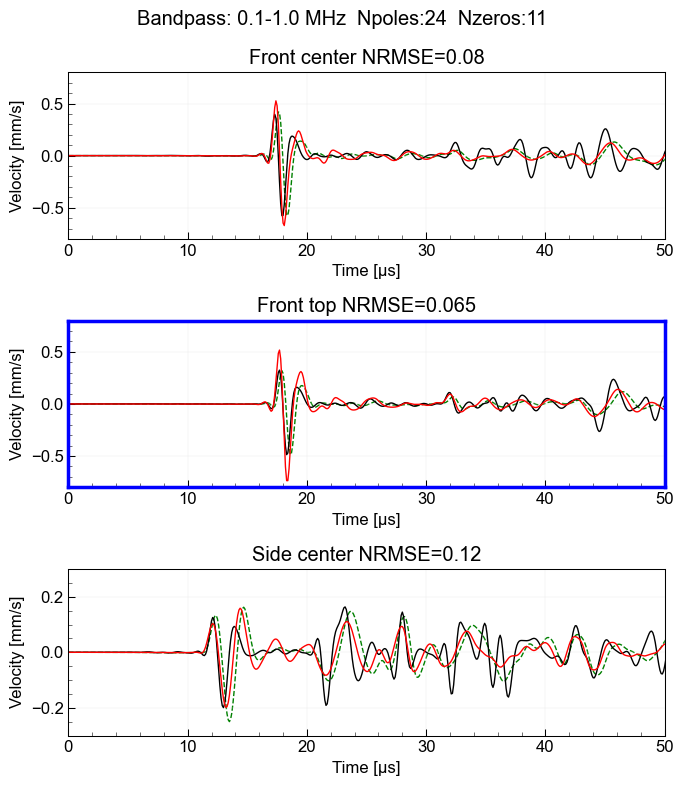

In [32]:
fig, axs = plt.subplots(3, 1, figsize=(7, 8), sharex=False)

xlimit = [0, 50]
ylimit_C00 = [-0.8, 0.8] #[-0.2, 0.2]
ylimit_C01 = [-0.8, 0.8] #[-0.12, 0.12]
ylimit_C02 = [-0.3, 0.3] #[-0.1, 0.1]

fig.suptitle("Bandpass: {:.1f}-{:.1f} MHz  Npoles:{:d}  Nzeros:{:d}".format(freqmin/1e6, freqmax/1e6, Npoles, Nzeros))
# fig.suptitle("Bandpass: {:.0f}-{:.0f}kHz  Npoles:{:d} Nzeros:{:d}  AIC:{:.2f}".format(freqmin/1e3, freqmax/1e3, Npoles, Nzeros, AIC_best))

tvec = tr_u.times()*1e6
#case 0
plotnormamp = np.max(np.abs(tr_y_C00_filtered.data))/np.max(np.abs(tr_u_C00_filtered.data))
axs[0].plot(tvec, tr_y_C00_filtered.data/plotnormamp*1e3, "g--", label="AE sensor Raw (not to scale)", zorder=-3, lw=1)
axs[0].plot(tvec, tr_u_C00_filtered.data*1e3, "k-", label="LDV", lw=1)
axs[0].plot(tvec, tr_inv_C00_filtered.data*1e3, "r-", label="Inverted", lw=1)
# nmse00 = compute_NMSE(tr_inv_C00_filtered.data, tr_u_C00_filtered.data)
nrmse00 = compute_NRMSE(tr_u_C00_filtered.data, tr_inv_C00_filtered.data)
axs[0].set_title("Front center NRMSE={:.2g}".format(nrmse00))
axs[0].set_xlim(xlimit)
axs[0].set_ylim(ylimit_C00)
axs[0].set_xlabel("Time [μs]")
axs[0].set_ylabel("Velocity [mm/s]")

# add legend
# axs[0].legend(loc=2, fontsize=10)

#case 1
plotnormamp = np.max(np.abs(tr_y_C01_filtered.data))/np.max(np.abs(tr_u_C01_filtered.data))
axs[1].plot(tvec, tr_y_C01_filtered.data/plotnormamp*1e3, "g--", label="AE sensor Raw (not to scale)", zorder=-3, lw=1)
axs[1].plot(tvec, tr_u_C01_filtered.data*1e3, "k-", label="LDV", lw=1)
axs[1].plot(tvec, tr_inv_C01_filtered.data*1e3, "r-", label="Inverted", lw=1)
# axs[1].legend(loc=2)
# nmse01 = compute_NMSE(tr_inv_C01_filtered.data, tr_u_C01_filtered.data)
nrmse01 = compute_NRMSE(tr_u_C01_filtered.data, tr_inv_C01_filtered.data)
axs[1].set_title("Front top NRMSE={:.2g}".format(nrmse01))
axs[1].set_xlim(xlimit)
axs[1].set_ylim(ylimit_C01)
axs[1].set_xlabel("Time [μs]")
axs[1].set_ylabel("Velocity [mm/s]")

#case 2
plotnormamp = np.max(np.abs(tr_y_C02_filtered.data))/np.max(np.abs(tr_u_C02_filtered.data))
axs[2].plot(tvec, tr_y_C02_filtered.data/plotnormamp*1e3, "g--", label="AE sensor Raw (not to scale)", zorder=-3, lw=1)
axs[2].plot(tvec, tr_u_C02_filtered.data*1e3, "k-", label="LDV", lw=1)
axs[2].plot(tvec, tr_inv_C02_filtered.data*1e3, "r-", label="Inverted", lw=1)
# axs[2].legend(loc=2)
# nmse02 = compute_NMSE(tr_inv_C02_filtered.data, tr_u_C02_filtered.data)
nrmse02 = compute_NRMSE(tr_u_C02_filtered.data, tr_inv_C02_filtered.data)
axs[2].set_title("Side center NRMSE={:.2g}".format(nrmse02))
axs[2].set_xlim(xlimit)
axs[2].set_ylim(ylimit_C02)
axs[2].set_xlabel("Time [μs]")
axs[2].set_ylabel("Velocity [mm/s]")

# axs[0].legend(bbox_to_anchor=(1.01, 1))

for i in range(3):
    axs[i].grid(True, c=np.array([230, 230, 230])/255, lw=0.25, zorder=-1)
    axs[i].set_axisbelow('True')

fig.tight_layout()

if casename=="frontcenter":
    plt.setp(axs[0].spines.values(), linewidth=2.5, color="blue")
elif casename=="fronttop":
    plt.setp(axs[1].spines.values(), linewidth=2.5, color="blue")
else:
    plt.setp(axs[2].spines.values(), linewidth=2.5, color="blue")

plt.savefig(figdir+"/FigS_AEcalib_validation_case_{}.eps".format(casename))


## Save data

In [27]:
NRMSE_all = np.array([nrmse00, nrmse01, nrmse02])

In [28]:
NRMSE_all
poles, zeros
gain = scale_fac/u_normfact # correct with u_normfact

d_data={"nrmse_all":NRMSE_all,
             "poles":poles,
             "zeros":zeros,
             "gain":gain}

In [29]:
foname="../data/PAZ_{}.mat".format(casename)
sio.savemat(foname, d_data)

In [30]:
casename

'fronttop'

# Appendix

Text(0.5, 0, 'Time [μs]')

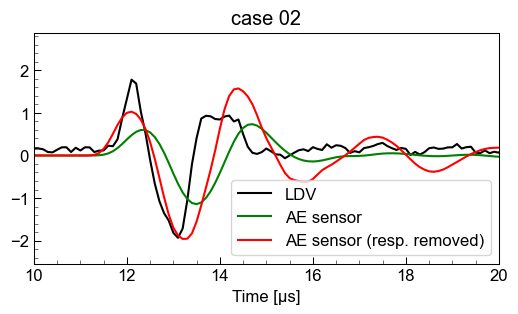

In [31]:

tr_u = st_u[2]
tr_y = st_y[2]

fig, ax = plt.subplots(1, 1, figsize=(6, 3))
tvec = tr_u.times()*1e6

ampnorm = 1e4
ax.plot(tvec, ampnorm * tr_u.data, "k-", label="LDV")
ax.plot(tvec, tr_y.data, "g-", label="AE sensor")
ax.plot(tvec, ampnorm * tr_removed_C02.data, "r-", label="AE sensor (resp. removed)")


ax.set_xlim([10, 20])
ax.legend()
ax.set_title("case 02")
ax.set_xlabel("Time [μs]")

